<a href="https://colab.research.google.com/github/clam920/COMP-2800-BBY-08/blob/main/Binary_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os
import torch
from transformers import BertTokenizer, AutoModelForSequenceClassification
# from transformers import XMLRobertaTokenizer
from transformers import AutoModel, AutoTokenizer
from transformers import RobertaTokenizer

# !pip install tensorflowjs

In [2]:
import torchvision

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
directory="/content/drive/MyDrive/Garbage_classification"
train_directory="/content/drive/MyDrive/Garbage_classification/train"
val_directory="/content/drive/MyDrive/Garbage_classification/validation"
test_directory="/content/drive/MyDrive/Garbage_classification/test"

In [5]:
train_datagen=ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=(0.5,1.5),
    zoom_range = [1, 1.5]
)

val_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

In [6]:
train_ds=train_datagen.flow_from_directory(train_directory,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  class_mode='sparse',batch_size=32)

val_ds=val_datagen.flow_from_directory(val_directory,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  class_mode='sparse',batch_size=32)

test_ds=test_datagen.flow_from_directory(test_directory,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  class_mode='sparse',batch_size=32)

Found 16501 images belonging to 8 classes.
Found 1183 images belonging to 8 classes.
Found 1184 images belonging to 8 classes.


In [7]:
from keras.applications import ResNet101V2

pretrained_model=ResNet101V2(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')

for layer in pretrained_model.layers:
  layer.trainable=False

171317808/171317808 [==============================] - 1s 0us/step


In [8]:
model=Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(BatchNormalization())
# model.add(Dense(1024,kernel_initializer='he_uniform'))
# model.add(Activation('relu'))
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(Dense(8, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (Batch  (None, 100352)            401408    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [9]:
opt=tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [ ]:
#  model.compile(optimizer=Adam(learning_rate=0.001),
#                loss='categorical_crossentropy',
#                metrics=['accuracy'])

In [11]:
history=model.fit(train_ds, validation_data=val_ds, epochs=4)

Epoch 1/4
516/516 [==============================] - 7857s 15s/step - loss: 1.0393 - accuracy: 0.8007 - val_loss: 0.7618 - val_accuracy: 0.8318
Epoch 2/4
516/516 [==============================] - 357s 691ms/step - loss: 0.3196 - accuracy: 0.8997 - val_loss: 0.4750 - val_accuracy: 0.8943
Epoch 3/4
516/516 [==============================] - 355s 688ms/step - loss: 0.2452 - accuracy: 0.9235 - val_loss: 0.4701 - val_accuracy: 0.9129
Epoch 4/4
516/516 [==============================] - 353s 684ms/step - loss: 0.2081 - accuracy: 0.9356 - val_loss: 0.5650 - val_accuracy: 0.9011


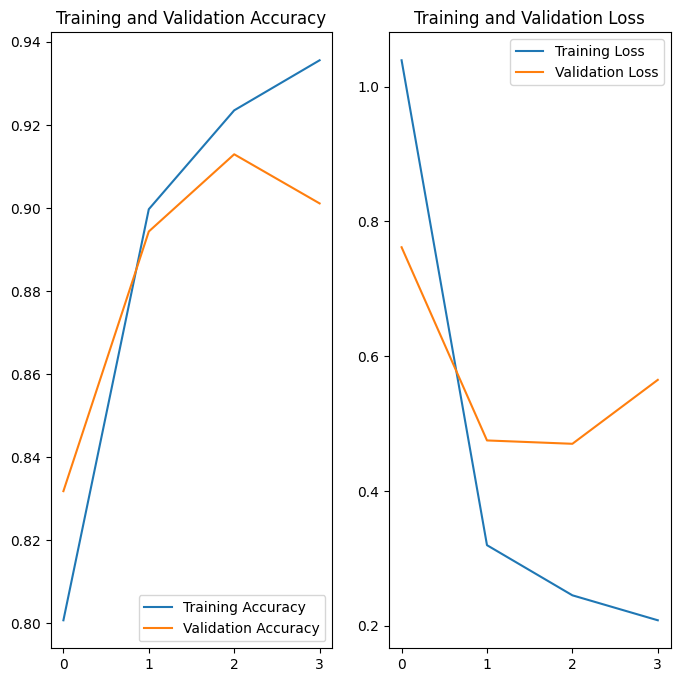

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(4)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
test_data = model.evaluate(
    x=test_ds,
    y=None,
    batch_size=32,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    return_dict=False
)

print(test_data)



37/37 [==============================] - 459s 13s/step - loss: 0.5191 - accuracy: 0.9155
[0.5190847516059875, 0.9155405163764954]


In [17]:
predict_data = model.predict(
    x=test_ds,
    verbose=0
)

print(predict_data)

[[1.9419666e-28 5.6976222e-27 1.0000000e+00 ... 3.1965057e-18
  1.3520547e-09 1.3426291e-12]
 [3.1620235e-07 3.5623753e-14 9.9992871e-01 ... 2.9444978e-11
  7.0796428e-05 1.3837011e-07]
 [1.8184561e-23 1.0000000e+00 5.9219720e-26 ... 1.9128672e-19
  3.5527569e-21 1.0938295e-20]
 ...
 [6.0297381e-02 3.4784433e-02 1.6473584e-03 ... 8.7290078e-01
  7.9486659e-04 6.8990318e-03]
 [7.6027198e-11 1.6948425e-05 1.1786663e-03 ... 9.9758887e-01
  1.1140981e-03 9.7948301e-05]
 [3.8848023e-07 3.2941206e-12 6.7177805e-04 ... 1.4715992e-11
  5.4217828e-08 4.9312016e-10]]


In [ ]:
# Defining list with labels
dic = ['Battery', 'Cardboard', 'Glass', 'Organic', 'Plastic', 'Paper', 'Metal', 'Trash']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(test_ds, verbose=0)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_ds.classes, y_pred))

In [ ]:
# Confusion Matrix is a two dimensional matrix that visualizes the performance,
# and makes it easy to see confusion between classes,
# by providing a picture of interrelation

# Each row represents a number of actual, True class
# Each column represents a number of predicted class


# Computing Confusion Matrix to evaluate accuracy of classification
c_m = confusion_matrix(test_ds.classes, y_pred)

# Showing Confusion Matrix in form of 2D Numpy array
print(c_m)

In [ ]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline


# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=dic)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='Blues', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)


# Showing the plot
plt.show()


In [20]:
model.save("/content/drive/MyDrive/model3.keras")

In [ ]:
# SAVE MODEL (KERAS, FOR REUSING)
model.save("/content/drive/MyDrive/Trained Model/model2.keras")
# OUTPUT: KERAS FILE

In [ ]:
# LOAD THE MODEL THAT WE JUST SAVED (helps us test without training model again)
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/Trained Model/model2.keras", custom_objects=None, compile=True, safe_mode=True
)

In [ ]:
model.summary();

In [ ]:
# TESTING, but just for one image
img = tf.keras.utils.load_img(
    "/content/drive/MyDrive/Garbage classification mini/metal/Copy of metal1.jpg", target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = img_array / 255.0
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

# print(predictions)
print(predictions[0]);

score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(dic[np.argmax(score)], 100 * np.max(score))
);

In [ ]:
# SAVE MODEL (JSON, FOR EXPORTING TO JAVASCRIPT)
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "/content/drive/MyDrive/Trained Model")
# OUTPUT: JSON + BIN FILES